In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import glob
from tqdm import tqdm
from patchify import patchify
# from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.python.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py
import tifffile
from tifffile import imread

seed = 56

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
input_dir = r'/content/drive/MyDrive/Satellite_Data/sat'
output_dir = r'/content/Data/sat'
# scale_percent = 30

for file_name in os.listdir(input_dir):
    if file_name.endswith(".tiff"):
        # Load the image
        img_path = os.path.join(input_dir, file_name)
        img = cv2.imread(img_path)

        # Get the new dimensions
        width = 1024
        height = 1024
        dim = (width, height)

        # Resize the image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        # Save the resized image
        out_path = os.path.join(output_dir, file_name)
        cv2.imwrite(out_path, resized)

In [ ]:
input_dir = r'/content/drive/MyDrive/Satellite_Data/map'
output_dir = r'/content/Data/map'
# scale_percent = 30

for file_name in os.listdir(input_dir):
    if file_name.endswith(".tif"):
        # Load the image
        img_path = os.path.join(input_dir, file_name)
        img = cv2.imread(img_path)

        # Get the new dimensions
        width = 1024
        height = 1024
        dim = (width, height)

        # Resize the image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        # Save the resized image
        out_path = os.path.join(output_dir, file_name)
        cv2.imwrite(out_path, resized)

In [ ]:
# # Path to the directory containing the TIFF images
# input_directory = r'/content/Data/sat'

# # Path to the directory where the HDF5 files will be stored
# output_directory = r'/content/HDF5_Dataset/sat'

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# # Loop through all TIFF images in the input directory
# for filename in os.listdir(input_directory):
#     # Skip files that are not TIFF images
#     if not filename.endswith('.tiff'):
#         continue
    
#     # Read the TIFF image data
#     image = cv2.imread(os.path.join(input_directory, filename))
    
#     # Create the HDF5 file
#     hdf5_file = h5py.File(os.path.join(output_directory, filename + '.h5py'), 'w')
    
#     # Create a dataset in the HDF5 file to store the image data
#     image_dataset = hdf5_file.create_dataset('image', data=image, compression='gzip')
    
#     # Close the HDF5 file
#     hdf5_file.close()

In [ ]:
# # Path to the directory containing the TIFF images
# input_directory = r'/content/Data/map'

# # Path to the directory where the HDF5 files will be stored
# output_directory = r'/content/HDF5_Dataset/map'

# # Create the output directory if it doesn't exist
# if not os.path.exists(output_directory):
#     os.makedirs(output_directory)

# # Loop through all TIFF images in the input directory
# for filename in os.listdir(input_directory):
#     # Skip files that are not TIFF images
#     if not filename.endswith('.tif'):
#         continue
    
#     # Read the TIFF image data
#     image = cv2.imread(os.path.join(input_directory, filename))
    
#     # Create the HDF5 file
#     hdf5_file = h5py.File(os.path.join(output_directory, filename + '.hdf5'), 'w')
    
#     # Create a dataset in the HDF5 file to store the image data
#     image_dataset = hdf5_file.create_dataset('image', data=image, compression='gzip')
    
#     # Close the HDF5 file
#     hdf5_file.close()

In [ ]:
WORKING_DIR = r'/content/Data'
NUMBER_OF_IMAGES = 49 #You can put maximum of 5598 i.e. equal to `len(TRAIN_IMG)`
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
PATCH_SIZE = 256
IMG_CHANNEL = 3
IOU_THRESHOLD = 0.7

# Patches per image
NUMBER_OF_PATCHES_PER_IMG = int((IMG_WIDTH / PATCH_SIZE) * (IMG_WIDTH / PATCH_SIZE))
TOTAL_PATCHES = NUMBER_OF_IMAGES * NUMBER_OF_PATCHES_PER_IMG

In [ ]:
TRAIN_IMG = sorted(glob.glob(WORKING_DIR + '/sat/*.tiff'))
TRAIN_MASK = sorted(glob.glob(WORKING_DIR + '/map/*.tif'))

In [ ]:
image_dataset = []
for i, img in tqdm(enumerate(TRAIN_IMG)):
    if i== NUMBER_OF_IMAGES:
        break
    img_before_patch = cv2.imread(img) / 255
    img_patches = patchify(img_before_patch, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)
    img_patches = img_patches.reshape((NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE, 3))
    image_dataset.append(img_patches)

49it [00:02, 23.69it/s]


In [ ]:
images = np.array(image_dataset).reshape((NUMBER_OF_IMAGES * NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE, IMG_CHANNEL))
images.shape

(784, 256, 256, 3)

In [ ]:
mask_dataset = []
for i, mask in tqdm(enumerate(TRAIN_MASK)):
    if i == NUMBER_OF_IMAGES:
        break
    mask_before_patch = cv2.imread(mask)[:, :, 0]
    mask_patches = patchify(mask_before_patch, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE)
    mask_patches = mask_patches.reshape((NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE))
    mask_dataset.append(mask_patches)

49it [00:00, 76.87it/s]


In [ ]:
masks = np.array(mask_dataset).reshape((NUMBER_OF_IMAGES * NUMBER_OF_PATCHES_PER_IMG, PATCH_SIZE, PATCH_SIZE))
masks.shape

(784, 256, 256)

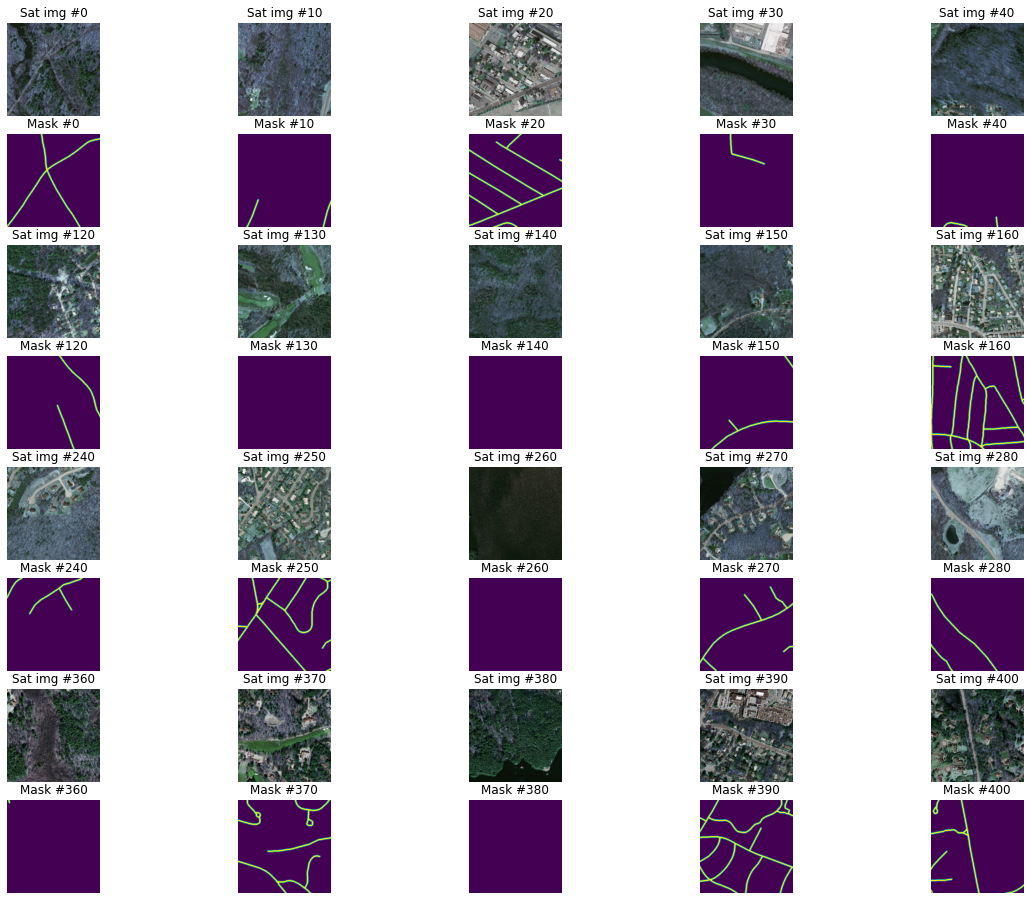

In [ ]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [ ]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3

In [ ]:
masks = np.expand_dims(masks, -1)

In [ ]:
print(masks.shape)
print(images.shape)

(784, 256, 256, 1)
(784, 256, 256, 3)


In [ ]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1-dice_coef(y_true, y_pred)

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.25, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(588, 256, 256, 3)
(588, 256, 256, 1)
TEST SET
(196, 256, 256, 3)
(196, 256, 256, 1)


In [ ]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.python.keras.metrics import MeanIoU
import keras

In [ ]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 8

In [ ]:
!pip install tensorboardcolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3858 sha256=537a9891ef33c6c7c291ebb8daf64720b0625e1a0e8e29f125829521145fead9
  Stored in directory: /root/.cache/pip/wheels/e5/6b/92/99a181b543b45a45df4346bcdf01aac1f882fe447c63302878
Successfully built tensorboardcolab


In [ ]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [ ]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://32d6-34-134-120-69.ngrok.io


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint("/content/Model/model_output1.h5", verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
    ]

In [ ]:
# from tensorflow.python.keras.optimizers import Adam

opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef], run_eagerly=True)

In [ ]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.15,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = callbacks
                       )

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.7891 - iou_coef: 0.1030
Epoch 1: val_loss did not improve from 0.90849
63/63 [==============================] - 14s 195ms/step - loss: 0.7891 - iou_coef: 0.1030 - val_loss: 0.9182 - val_iou_coef: 0.0411
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.7714 - iou_coef: 0.1124
Epoch 2: val_loss improved from 0.90849 to 0.87748, saving model to /content/Model/model_output1.h5
63/63 [==============================] - 11s 168ms/step - loss: 0.7714 - iou_coef: 0.1124 - val_loss: 0.8775 - val_iou_coef: 0.0611
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.7570 - iou_coef: 0.1224
Epoch 3: val_loss improved from 0.87748 to 0.81033, saving model to /content/Model/model_output1.h5
63/63 [==============================] - 11s 170ms/step - loss: 0.7570 - iou_coef: 0.1224 - val_loss: 0.8103 - val_iou_coef: 0.0956
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.7

In [ ]:
model.save(r"/content/Model/model_output1.h5")

In [ ]:
model = load_model("/content/Model/model_output1.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [ ]:
model.evaluate(test_images, test_masks/255)

7/7 [==============================] - 3s 186ms/step - loss: 0.3142 - iou_coef: 0.4333


[0.31421515345573425, 0.43329307436943054]

In [ ]:
predictions = model.predict(test_images, verbose=1)

7/7 [==============================] - 1s 88ms/step


In [ ]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

In [ ]:
print(len(predictions))

196


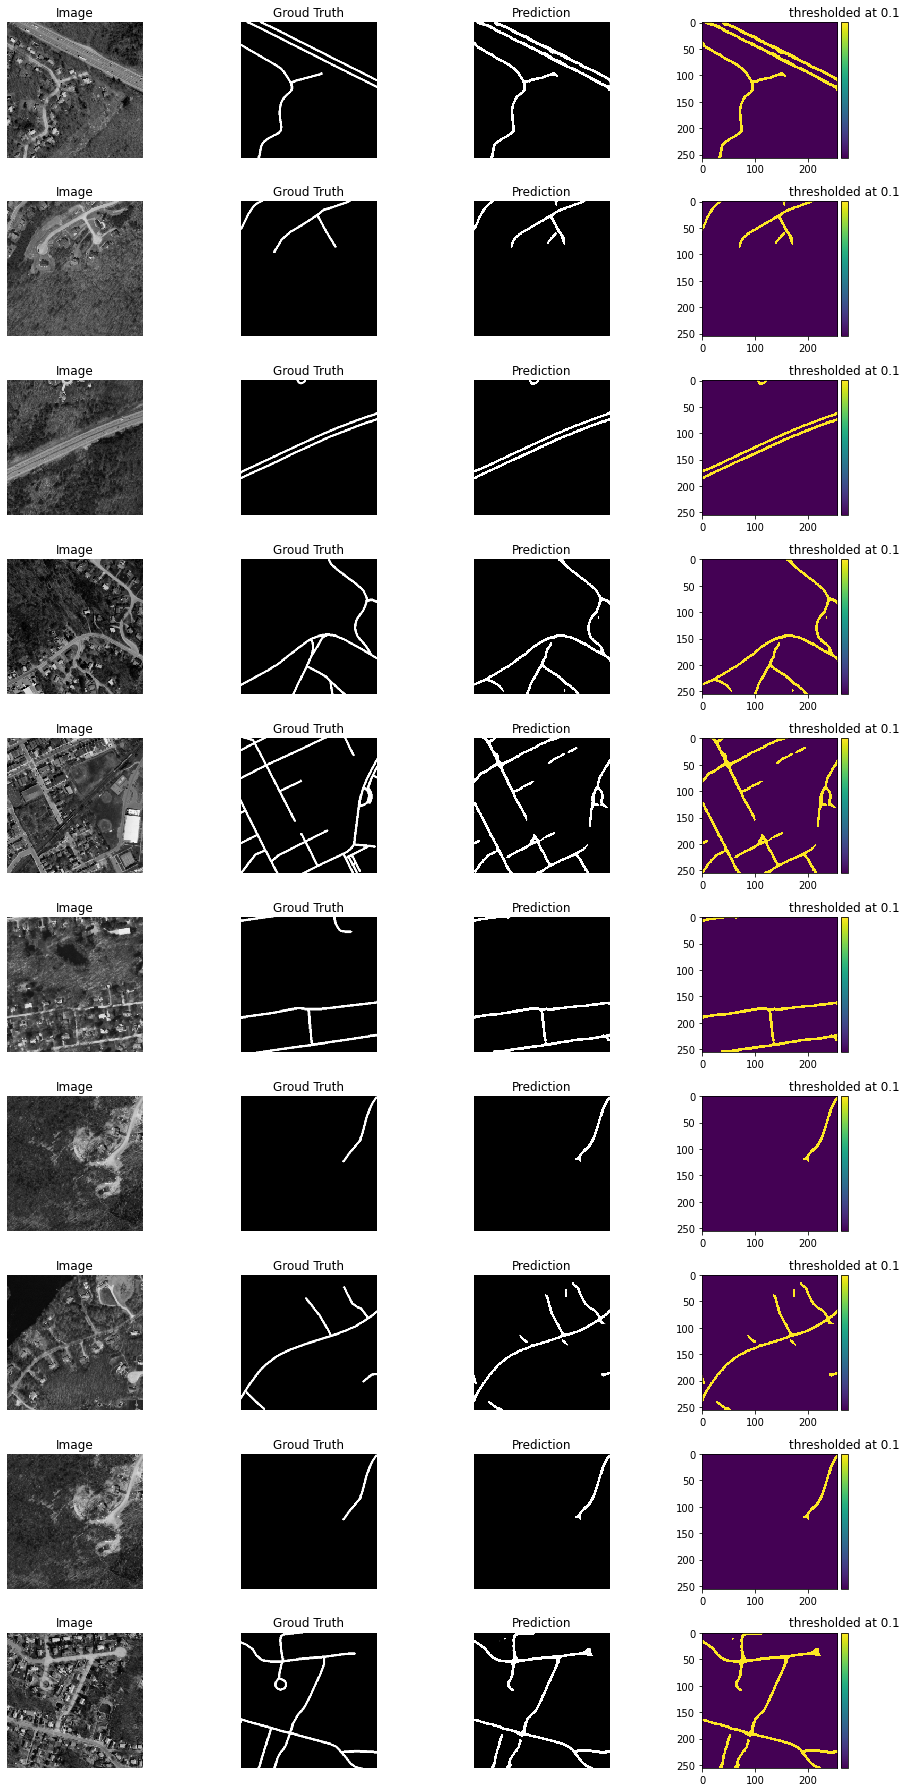

In [ ]:
ix = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()
